## 1. Setup and Install Dependencies



In [1]:
# Install dependencies
!pip install -q torchio
!pip install -q SimpleITK
!pip install -q git+https://github.com/alanqrwang/keymorph.git

# Clone BrainMorph repository
!rm -rf brainmorph
!git clone https://github.com/alanqrwang/brainmorph.git
!pip install -e brainmorph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Import Libraries

In [2]:
import os
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import subprocess
import pandas as pd

## 3. Preprocessing Functions


In [3]:
# Preprocessing: Convert MHD to NIfTI
def convert_mhd_to_nifti(mhd_path, output_path, shape=(160, 192, 144)):
    img = sitk.ReadImage(mhd_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    arr = resize(arr, shape, preserve_range=True)
    nib.save(nib.Nifti1Image(arr, affine=np.eye(4)), output_path)
    print("Saved:", output_path)


## 4. Single-Patient Registration


In [4]:
# @title [Important] Run this cell before the next step or the code will not work properly

# ===============================================
# update brainmorph/scripts/register.py
# ===============================================

# Define the corrected content as a multi-line string
corrected_register_code = """\
import re
import torch
import math
from collections import defaultdict
import os
import argparse
import json

try:
    import wandb
except ImportError as e:
    pass

def parse_test_mod(mod):
    if isinstance(mod, str):
        mod1, mod2 = mod.split("_")
    else:
        mod1, mod2 = mod
    return mod1, mod2

def parse_test_aug(aug):
    if "rot" in aug:
        if aug == "rot0":
            rot_aug = 0
        elif aug == "rot45":
            rot_aug = math.pi / 4
        elif aug == "rot90":
            rot_aug = math.pi / 2
        elif aug == "rot135":
            rot_aug = 3 * math.pi / 4
        elif aug == "rot180":
            rot_aug = math.pi
        aug_param = (0, 0, rot_aug, 0)
    else:
        raise NotImplementedError()
    return aug_param

def aggregate_dicts(dicts):
    result = defaultdict(list)
    for d in dicts:
        for k, v in d.items():
            result[k].append(v)
    return {k: sum(v) / len(v) for k, v in result.items()}

def initialize_wandb(config):
    if config.wandb_api_key_path is not None:
        with open(config.wandb_api_key_path, "r") as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    wandb.init(**config.wandb_kwargs)
    wandb.config.update(config)

def load_checkpoint(
    checkpoint_path, model, optimizer=None, scheduler=None, device="cpu"
):
    state = torch.load(checkpoint_path, map_location=torch.device(device), weights_only=False)
    state_dict = state["state_dict"]
    new_state_dict = {
        key.replace(".backbone", ""): value for key, value in state_dict.items()
    }
    missing_keys, _ = model.backbone.load_state_dict(new_state_dict, strict=True)
    print("Missing keys when loading checkpoint: ", missing_keys)
    res = (state, model)
    if optimizer:
        optimizer.load_state_dict(state["optimizer"])
        res += (optimizer,)
    if scheduler:
        scheduler.load_state_dict(state["scheduler"])
        res += (scheduler,)
    return res

class ParseKwargs(argparse.Action):
    def __call__(self, parser, namespace, values, option_string=None):
        setattr(namespace, self.dest, dict())
        for value in values:
            key, value_str = value.split("=")
            if value_str.replace("-", "").isnumeric():
                processed_val = int(value_str)
            elif value_str.replace("-", "").replace(".", "").isnumeric():
                processed_val = float(value_str)
            elif value_str in ["True", "true"]:
                processed_val = True
            elif value_str in ["False", "false"]:
                processed_val = False
            else:
                processed_val = value_str
            getattr(namespace, self.dest)[key] = processed_val

def summary(network):
    print("")
    print("Model Summary")
    print("---------------------------------------------------------------")
    for name, _ in network.named_parameters():
        print(name)
    print(
        "Total parameters:",
        sum(p.numel() for p in network.parameters() if p.requires_grad),
    )
    print("---------------------------------------------------------------")
    print("")

def save_dict_as_json(dict, save_path):
    with open(save_path, "w") as outfile:
        json.dump(dict, outfile, sort_keys=True, indent=4)

def load_dict_from_json(json_path):
    with open(json_path, "r") as file:
        data = json.load(file)
    return data

def get_latest_epoch_file(directory_path, args):
    max_epoch = -1
    latest_epoch_file = None
    if args.run_mode == "pretrain":
        epoch_pattern = re.compile(r"pretrained_epoch(\d+)_model\.pth\.tar")
    else:
        epoch_pattern = re.compile(r"epoch(\d+)_trained_model.pth.tar")
    for filename in os.listdir(directory_path):
        match = epoch_pattern.match(filename)
        if match:
            epoch_num = int(match.group(1))
            if epoch_num > max_epoch:
                max_epoch = epoch_num
                latest_epoch_file = filename
    if latest_epoch_file is not None:
        return os.path.join(directory_path, latest_epoch_file)
    else:
        return None
"""

# Write to the correct file
register_path = "brainmorph/scripts/script_utils.py"
with open(register_path, "w") as f:
    f.write(corrected_register_code)

print(f"✅ Successfully updated {register_path}. Ready for registration.")


✅ Successfully updated brainmorph/scripts/script_utils.py. Ready for registration.


In [5]:
# Paths


ct_mhd = "/content/drive/MyDrive/Data/rire/109/ct/patient_109_ct.mhd"
mri_mhd = "/content/drive/MyDrive/Data/rire/109/mr_T1/patient_109_mr_T1.mhd"

# replace with
# ct_mhd = "dataset/rire/109/ct/patient_109_ct.mhd"
# mri_mhd = "dataset/rire/109/mr_T1/patient_109_mr_T1.mhd"

# Create output folder
os.makedirs("example_data", exist_ok=True)

# Convert CT and MRI
convert_mhd_to_nifti(ct_mhd, "example_data/fixed_rire.nii.gz")
convert_mhd_to_nifti(mri_mhd, "example_data/moving_rire.nii.gz")

# Run BrainMorph registration
!python brainmorph/scripts/register.py \
  --num_keypoints 128 \
  --variant S \
  --weights_dir brainmorph/weights/ \
  --moving example_data/moving_rire.nii.gz \
  --fixed example_data/fixed_rire.nii.gz \
  --list_of_aligns rigid affine tps_1 \
  --list_of_metrics mse \
  --save_eval_to_disk \
  --save_dir register_output/ \
  --visualize \
  --download

Saved: example_data/fixed_rire.nii.gz
Saved: example_data/moving_rire.nii.gz
Number of GPUs: 1

Model Summary
---------------------------------------------------------------
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv1.conv.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv2.conv.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv1.conv.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv2.conv.weight
backbone.module.encoders.2

## 5. Visualization


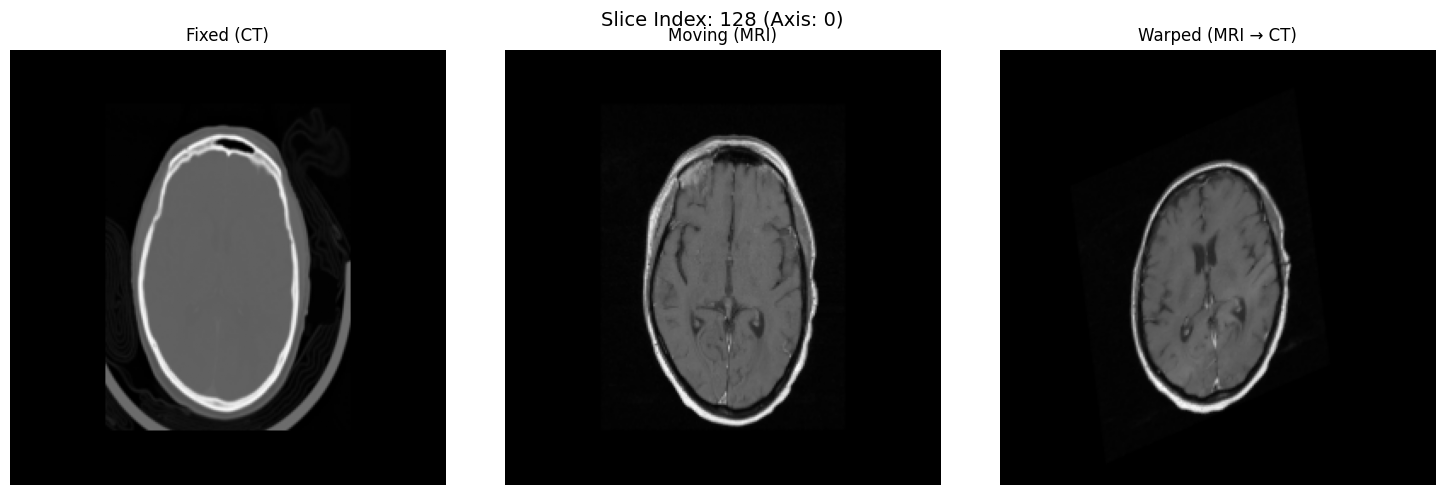

In [8]:
# Load registered images
fixed = np.load("./register_output/0_0_fixed_moving/img_f_0-fixed.npy").squeeze()
moving = np.load("./register_output/0_0_fixed_moving/img_m_0-moving-rot0.npy").squeeze()
warped = np.load("./register_output/0_0_fixed_moving/img_a_0-fixed_0-moving-rot0-tps_1.npy").squeeze()

# Choose slice
axis = 0
slice_idx = fixed.shape[axis] // 2

# Extract slices
fixed_slice = np.take(fixed, slice_idx, axis=axis)
moving_slice = np.take(moving, slice_idx, axis=axis)
warped_slice = np.take(warped, slice_idx, axis=axis)

# Plot
plt.figure(figsize=(15, 5))
titles = ['Fixed (CT)', 'Moving (MRI)', 'Warped (MRI → CT)']
for i, (img, title) in enumerate(zip([fixed_slice, moving_slice, warped_slice], titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.suptitle(f"Slice Index: {slice_idx} (Axis: {axis})", fontsize=14)
plt.tight_layout()
plt.show()


## 6. Compute Evaluation Metrics


In [9]:
# Normalize
def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

fixed_norm = normalize(fixed_slice)
warped_norm = normalize(warped_slice)

# Compute SSIM and MSE
mse_val = mean_squared_error(fixed_norm.flatten(), warped_norm.flatten())
ssim_val = ssim(fixed_norm, warped_norm, data_range=1.0)

print(f"📏 MSE: {mse_val:.4f}")
print(f"📸 SSIM: {ssim_val:.4f}")


📏 MSE: 0.0214
📸 SSIM: 0.6829


## 7. Full Dataset Batch Registration


In [11]:
# Paths
BASE_DIR = "/content/drive/MyDrive/Data/rire" # replace with /dataset/rire/
EXAMPLE_DIR = "example_data"
REGISTER_SCRIPT = "brainmorph/scripts/register.py"
RESULTS_DIR = "brainmorph_batch_results"
VIS_DIR = os.path.join(RESULTS_DIR, "visuals")
CSV_PATH = os.path.join(RESULTS_DIR, "brainmorph_results.csv")
TARGET_SHAPE = (256, 256, 256)

# Setup
os.makedirs(EXAMPLE_DIR, exist_ok=True)
os.makedirs(VIS_DIR, exist_ok=True)
results = []

# Helper functions
def mhd_to_nifti(mhd_path, output_path, target_shape=TARGET_SHAPE):
    img = sitk.ReadImage(mhd_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    resized = resize(arr, target_shape, preserve_range=True)
    nib.save(nib.Nifti1Image(resized, np.eye(4)), output_path)

def extract_center_slice(volume, axis=0):
    return np.take(volume, volume.shape[axis] // 2, axis=axis)

def run_brainmorph_registration(fixed_path, moving_path, output_dir):
    os.makedirs("logs", exist_ok=True)
    log_file = os.path.join("logs", os.path.basename(output_dir) + ".txt")
    with open(log_file, "w") as log:
        cmd = [
            "python", REGISTER_SCRIPT,
            "--num_keypoints", "128",
            "--variant", "S",
            "--weights_dir", "brainmorph/weights/",
            "--moving", moving_path,
            "--fixed", fixed_path,
            "--list_of_aligns", "tps_1",
            "--list_of_metrics", "mse",
            "--save_eval_to_disk",
            "--save_dir", output_dir,
            "--visualize",
            "--download"
        ]
        subprocess.run(cmd, stdout=log, stderr=log, check=True)

# Batch loop
for folder in tqdm(sorted(os.listdir(BASE_DIR))):
    if not folder.isdigit():
        continue

    pid = folder
    ct_path = os.path.join(BASE_DIR, pid, "ct", f"patient_{pid}_ct.mhd")
    mri_path = os.path.join(BASE_DIR, pid, "mr_T1", f"patient_{pid}_mr_T1.mhd")

    if not os.path.exists(ct_path) or not os.path.exists(mri_path):
        print(f"⚠️ Missing data for patient {pid}")
        continue

    print(f"🧠 Running BrainMorph for patient {pid}")

    fixed_path = os.path.join(EXAMPLE_DIR, "fixed_rire.nii.gz")
    moving_path = os.path.join(EXAMPLE_DIR, "moving_rire.nii.gz")
    output_dir = os.path.join(RESULTS_DIR, pid)
    os.makedirs(output_dir, exist_ok=True)

    # Preprocessing
    mhd_to_nifti(ct_path, fixed_path)
    mhd_to_nifti(mri_path, moving_path)

    try:
        run_brainmorph_registration(fixed_path, moving_path, output_dir)
    except subprocess.CalledProcessError:
        print(f"BrainMorph failed on patient {pid}")
        continue

    try:
        output_subdir = os.path.join(output_dir, "0_0_fixed_moving")
        warped = np.load(os.path.join(output_subdir, "img_a_0-fixed_0-moving-rot0-tps_1.npy")).squeeze()
    except FileNotFoundError:
        print(f"Missing warped image for patient {pid}")
        continue

    fixed = nib.load(fixed_path).get_fdata()
    moving = nib.load(moving_path).get_fdata()

    # Evaluate
    fixed_slice = extract_center_slice(fixed)
    warped_slice = extract_center_slice(warped)

    ssim_val = ssim(fixed_slice, warped_slice, data_range=1.0)
    mse_val = mean_squared_error(fixed_slice, warped_slice)

    # Visualize
    vis_path = os.path.join(VIS_DIR, f"patient_{pid}.png")
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip([fixed_slice, moving_slice, warped_slice],
                                        ['Fixed (CT)', 'Moving (MRI)', 'Warped MRI→CT'])):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.suptitle(f"Patient {pid} | SSIM: {ssim_val:.4f}, MSE: {mse_val:.4f}")
    plt.tight_layout()
    plt.savefig(vis_path)
    plt.close()

    results.append({
        "patient": pid,
        "ssim": ssim_val,
        "mse": mse_val
    })

# Save results
df = pd.DataFrame(results)
df.to_csv(CSV_PATH, index=False)
print(f"CSV saved to {CSV_PATH}")

  0%|          | 0/14 [00:00<?, ?it/s]

🧠 Running BrainMorph for patient 02


  7%|▋         | 1/14 [00:26<05:39, 26.10s/it]

🧠 Running BrainMorph for patient 03


 14%|█▍        | 2/14 [00:51<05:07, 25.63s/it]

🧠 Running BrainMorph for patient 04


 21%|██▏       | 3/14 [01:16<04:37, 25.21s/it]

🧠 Running BrainMorph for patient 05


 29%|██▊       | 4/14 [01:41<04:11, 25.15s/it]

🧠 Running BrainMorph for patient 06


 36%|███▌      | 5/14 [02:07<03:49, 25.45s/it]

🧠 Running BrainMorph for patient 07


 43%|████▎     | 6/14 [02:32<03:23, 25.47s/it]

🧠 Running BrainMorph for patient 101


 50%|█████     | 7/14 [02:59<03:00, 25.79s/it]

🧠 Running BrainMorph for patient 102


 57%|█████▋    | 8/14 [03:25<02:35, 25.88s/it]

🧠 Running BrainMorph for patient 103


 64%|██████▍   | 9/14 [03:50<02:09, 25.82s/it]

🧠 Running BrainMorph for patient 104


 71%|███████▏  | 10/14 [04:17<01:44, 26.01s/it]

🧠 Running BrainMorph for patient 105


 79%|███████▊  | 11/14 [04:43<01:18, 26.18s/it]

🧠 Running BrainMorph for patient 107


 86%|████████▌ | 12/14 [05:10<00:52, 26.25s/it]

🧠 Running BrainMorph for patient 108


 93%|█████████▎| 13/14 [05:36<00:26, 26.39s/it]

🧠 Running BrainMorph for patient 109


100%|██████████| 14/14 [06:00<00:00, 25.77s/it]

CSV saved to brainmorph_batch_results/brainmorph_results.csv
